In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 204.2MB 62kB/s 
     |████████████████████████████████| 204kB 44.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=65557f803a706266b9c93d986a5776cfe99e403dfef50dd8f7aebc15ff093412
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [2]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [6]:
df_mob = spark.read.format("csv").option("header", "true").load("drive/MyDrive/2020_US_Region_Mobility_Report.csv")
print((df_mob.count(), len(df_mob.columns)))

(727719, 14)


In [16]:
req_col_list = ['date', 'retail_and_recreation_percent_change_from_baseline',\
                           'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline',\
                           'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']

def convert_req(df_spark):
    df_pd = df_spark.toPandas()
    df_pd = df_pd[req_col_list]
    df_pd = df_pd.set_index(['date']) 
    return df_pd

In [17]:
from sklearn.preprocessing import MinMaxScaler

def data_scaler(df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled

In [24]:
from scipy.signal import savgol_filter

def plot_foot_traffic(df_scaled):
    cols = df_scaled.columns
    filter_window = 91
    fig = plt.figure(figsize = (17, 10))

    for i in range(len(cols)):
        plt.plot(savgol_filter(df_scaled[cols[i]], filter_window, 3), linewidth=2.5)

    plt.rcParams.update({'font.size': 14})
    plt.legend(cols)

    leg = plt.legend(cols)
    leg_lines = leg.get_lines()
    plt.setp(leg_lines, linewidth=4)

    plt.xlabel("Days(from Feb-15)")
    plt.ylabel("Percentage change in foot traffic",fontsize=16) 
    plt.title('Foot traffic for US',fontsize=16) 
    plt.show() 

    return

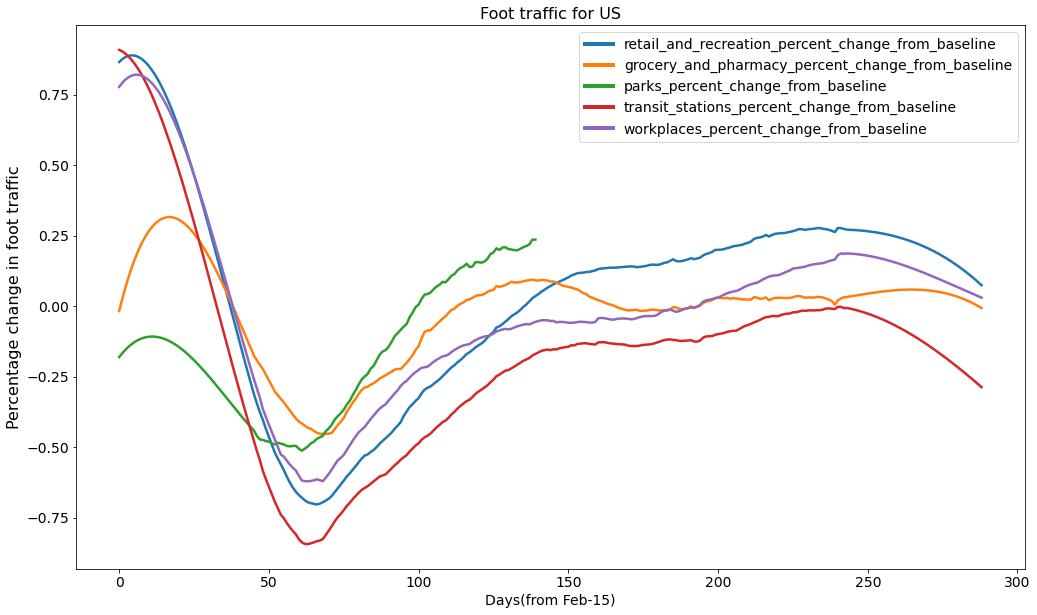

In [28]:
df_pd = convert_req(spark_df)
df_scaled = data_scaler(df_pd)
plot_foot_traffic(df_scaled)